# Dataset Student-Por

Questo dataset contiene informazioni familiari, sociali, di salute e scolastiche di un gruppo di studenti di una scuola secondaria. Tra queste, i voti di fine anno e il consumo di alcoolici durante la settimana e nel weekend.

i 3 obiettivi di questo progetto sono:
- analizzare il dataset e le relazioni tra le sue variabili
- addrestrare e confrontare modelli per predire il voto finale di uno studente
- capire quali sono i fattori che influiscono maggiormente sul voto finale degli studenti

### Importo librerie


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gs
from scipy import stats
from sklearn.preprocessing import LabelEncoder  
import warnings
warnings.filterwarnings('ignore')

### Funzioni utili

Ho copiato delle funzioni che ci servono per misurare le relazioni tra le variabili

In [ ]:
#fonte: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
#https://github.com/shakedzy/dython/blob/master/dython/nominal.py
import math
import scipy.stats as ss
def convert(data, to, copy=True):
    """
    aggiungerei un po' di documentazione / commenti
    """
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data.copy() if copy else data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data.copy() if copy else data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data.copy(deep=True) if copy else data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            'cannot handle data conversion of type: {} to {}'.format(
                type(data), to))
    else:
        return converted
def cramers_v(x, y):
   
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



def correlation_ratio(categories,
                      measurements):
    """
    Calculates the Correlation Ratio (sometimes marked by the greek letter Eta)
    for categorical-continuous association.
    Answers the question - given a continuous value of a measurement, is it
    possible to know which category is it associated with?
    Value is in the range [0,1], where 0 means a category cannot be determined
    by a continuous measurement, and 1 means a category can be determined with
    absolute certainty.
    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio
    Parameters:
    -----------
    categories : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    measurements : list / NumPy ndarray / Pandas Series
        A sequence of continuous measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    Returns:
    --------
    float in the range of [0,1]
    """
    
    categories = convert(categories, 'array')
    measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(
        np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg),
                                      2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta


### Funzioni per migliorare barplot

In [ ]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            plot.annotate(percentage, (x, y), size = 12)
   # plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.2
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
    #plt.show()

## Indice dei contenuti:
* [Descrizione Variabili dataset](#first-bullet)
* [Analisi Dataset](#second-bullet)
* [Predizione voto finale G3](#third-bullet)
* [Quali fattori influiscono maggiormente sul voto finale?](#fourth-bullet)


# Descrizione Variabili dataset <a class="anchor" id="first-bullet"></a>

Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:

school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)

sex - student's sex (binary: 'F' - female or 'M' - male)

age - student's age (numeric: from 15 to 22)

address - student's home address type (binary: 'U' - urban or 'R' - rural)

famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)

Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)

Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)

Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)

Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')

Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')

reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')

guardian - student's guardian (nominal: 'mother', 'father' or 'other')

traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)

studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)

failures - number of past class failures (numeric: n if 1<=n<3, else 4)

schoolsup - extra educational support (binary: yes or no)

famsup - family educational support (binary: yes or no)

paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)

activities - extra-curricular activities (binary: yes or no)

nursery - attended nursery school (binary: yes or no)

higher - wants to take higher education (binary: yes or no)

internet - Internet access at home (binary: yes or no)

romantic - with a romantic relationship (binary: yes or no)

famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)

freetime - free time after school (numeric: from 1 - very low to 5 - very high)

goout - going out with friends (numeric: from 1 - very low to 5 - very high)

Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)

Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)

health - current health status (numeric: from 1 - very bad to 5 - very good)

absences - number of school absences (numeric: from 0 to 93)

These grades are related with the course subject, Math or Portuguese:

G1 - first period grade (numeric: from 0 to 20)

G2 - second period grade (numeric: from 0 to 20)

G3 - final grade (numeric: from 0 to 20, output target)


## 1 - Analisi Dataset <a class="anchor" id="second-bullet"></a>


### Carico Dataset

In [ ]:
df = pd.read_csv("student-por.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### Info Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [ ]:
df.shape

(649, 33)

Il dataset contiene 649 osservazioni e 33 variabili

### Dati mancanti

In [ ]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Non sono presenti dati mancanti nel dataset. Per analizzare come hanno gestito eventuali dati mancanti, andremo ad analizzare le distribuzioni delle variabili.

### Struttura dataset

Dividiamo il dataset in base al tipo di variabile:
- quantitativa 
- qualitativa ordinale
- qualitativa nominale
- qualitativa nominale binaria

In [ ]:
cont = ["age", "absences", "G1", "G2", "G3"]
ordin = ["Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health"]
nom = ["Mjob", "Fjob", "reason", "guardian"]
binary = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]

### Distribuzione variabili continue
Iniziamo analizzando la distribuzione delle variabili quantitative

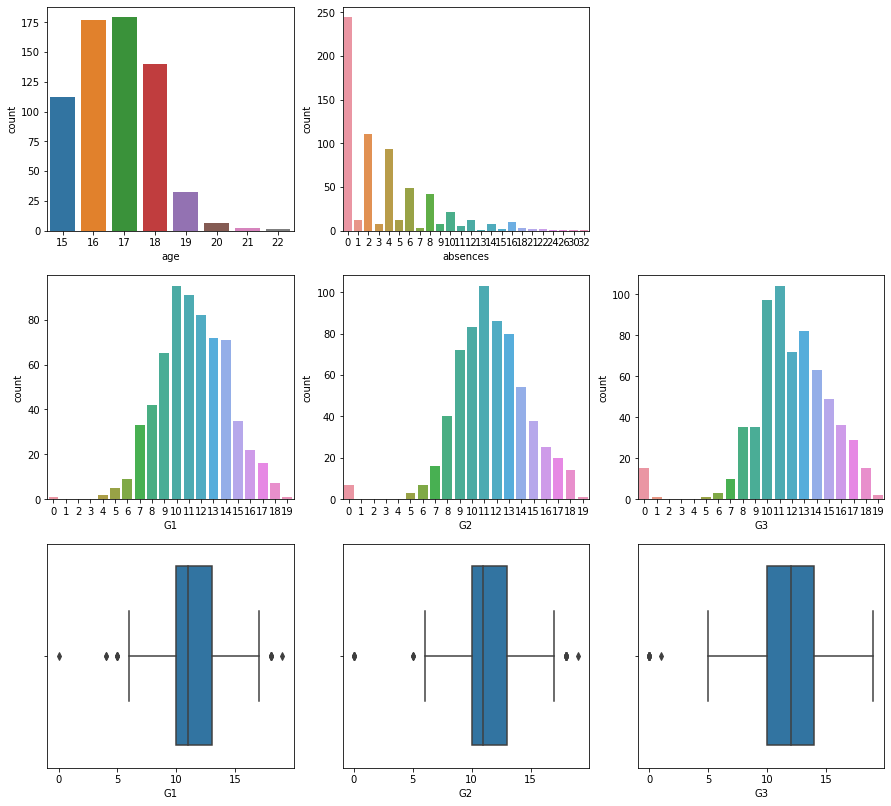

In [ ]:
#distribuzione features continue
fig = plt.figure(figsize = (15,14))
g = gs.GridSpec(nrows = 3, ncols = 3, figure = fig)
i = 0

ax1 = plt.subplot(g[0,0])
ax1 = sns.countplot(df[cont[0]])

ax2 = plt.subplot(g[0,1])
ax2 = sns.countplot(df[cont[1]])

rg = list(range(0,20))
for feature in cont[2:]:
    ax = plt.subplot(g[1,i])
    ax = sns.countplot(df[feature], order = rg)
    i = i+1
i = 0
for feature in cont[2:]:
    ax = plt.subplot(g[2,i])
    ax = sns.boxplot(data = df, x = df[feature], order = rg)
    i = i+1

- Gli studenti hanno per la maggior parte età <= a 19
- Gran parte degli studenti non ha mai fatto assenze. Troviamo però delle eccezioni dopo le 10 assenze, con una minoranza che ha raggiunto anche 32 assenze
- I voti hanno una distribuzione normale, anche se in G2 e G3 notiamo un piccolo gruppo di studenti che ha preso 0

In [ ]:
df[df["G3"] == 0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
163,GP,M,18,U,LE3,T,1,1,other,other,...,2,3,5,2,5,4,0,11,9,0
440,MS,M,16,U,GT3,T,1,1,at_home,services,...,5,4,5,4,5,3,0,7,0,0
519,MS,M,16,R,GT3,T,2,1,other,services,...,5,2,1,1,1,2,0,8,7,0
563,MS,M,17,U,GT3,T,2,2,other,other,...,1,2,1,2,3,5,0,7,0,0
567,MS,M,18,R,GT3,T,3,2,services,other,...,2,3,1,2,2,5,0,4,0,0
583,MS,F,18,R,GT3,T,2,2,other,other,...,5,5,5,1,1,3,0,8,6,0
586,MS,F,17,U,GT3,T,4,2,teacher,services,...,5,5,5,1,3,5,0,8,8,0
597,MS,F,18,R,GT3,T,2,2,at_home,other,...,4,3,3,1,1,4,0,9,0,0
603,MS,F,18,R,LE3,A,4,2,teacher,other,...,5,3,1,1,1,5,0,5,0,0
605,MS,F,19,U,GT3,T,1,1,at_home,services,...,5,5,5,2,3,2,0,5,0,0


Questi sono i 33 studenti con G3 = 0. Notiamo che la media dei voti G1 e G2 di qeusti studenti è minore o uguale a 10, quindi può darsi che non abbiano raggiunto la sufficienza per sostenere l'ultimo esame, prendendo automaticamente G3 = 0.

Vale anche il contrario?

In [ ]:
df[(df["G3"] > 0) & (df["G3"] < 7.5)]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
18,GP,M,17,U,GT3,T,3,2,services,services,...,5,5,5,2,4,5,2,8,8,7
155,GP,M,17,U,GT3,T,2,1,other,other,...,5,4,5,1,2,5,22,9,7,6
172,GP,M,16,U,GT3,T,3,3,other,services,...,4,5,5,4,4,5,0,10,10,1
255,GP,F,18,U,GT3,T,3,3,other,other,...,4,1,1,1,1,3,14,8,7,7
279,GP,M,22,U,GT3,T,3,1,services,services,...,5,4,5,5,5,1,12,7,8,5
282,GP,M,18,U,GT3,T,3,2,services,other,...,4,4,5,2,4,5,8,7,8,7
284,GP,M,18,U,GT3,T,2,1,services,services,...,3,2,5,2,5,5,4,7,8,6
432,MS,F,17,R,GT3,T,1,1,other,other,...,5,4,4,2,2,5,0,6,6,7
500,MS,M,17,U,GT3,T,1,2,other,other,...,5,3,5,5,5,1,12,6,7,7
512,MS,F,18,R,GT3,T,1,1,at_home,other,...,4,3,2,1,1,5,9,7,7,7


Purtroppo queste righe non rispettano la nostra ipotesi, infatti notiamo che ci sono studenti che hanno un voto G3 maggiore di 0 ma con una media dei primi 2 voti minore o uguale a 10.

Notiamo però come tutti gli studenti che hanno G3 = 0 o 1 hanno tutti 0 assenze. Analizziamo la distribuzione della variabile "absences". 

Nella prima tabella notiamo degli studenti che hanno anche G2 = 0. Analizziamo anche la variabile "G2"

In [ ]:
df[df["G2"] == 0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
440,MS,M,16,U,GT3,T,1,1,at_home,services,...,5,4,5,4,5,3,0,7,0,0
563,MS,M,17,U,GT3,T,2,2,other,other,...,1,2,1,2,3,5,0,7,0,0
567,MS,M,18,R,GT3,T,3,2,services,other,...,2,3,1,2,2,5,0,4,0,0
597,MS,F,18,R,GT3,T,2,2,at_home,other,...,4,3,3,1,1,4,0,9,0,0
603,MS,F,18,R,LE3,A,4,2,teacher,other,...,5,3,1,1,1,5,0,5,0,0
605,MS,F,19,U,GT3,T,1,1,at_home,services,...,5,5,5,2,3,2,0,5,0,0
610,MS,F,19,R,GT3,A,1,1,at_home,at_home,...,3,5,4,1,4,1,0,8,0,0


La documentazione più approfondita del dataset non esiste più. Ipotizziamo che queste persone hanno lasciato la scuola prima del test finale(notiamo anche che alcune persone con G3 = 0 hanno anche G2 = 0), e quindi per questi studenti hanno messo absences = 0. Togliamo questi studenti dal dataset.

In [ ]:
df = df[df["G3"] != 0]
df = df[df["G3"] != 1]

Analizziamo ora come sono distribuite le variabili qualitative ordinali

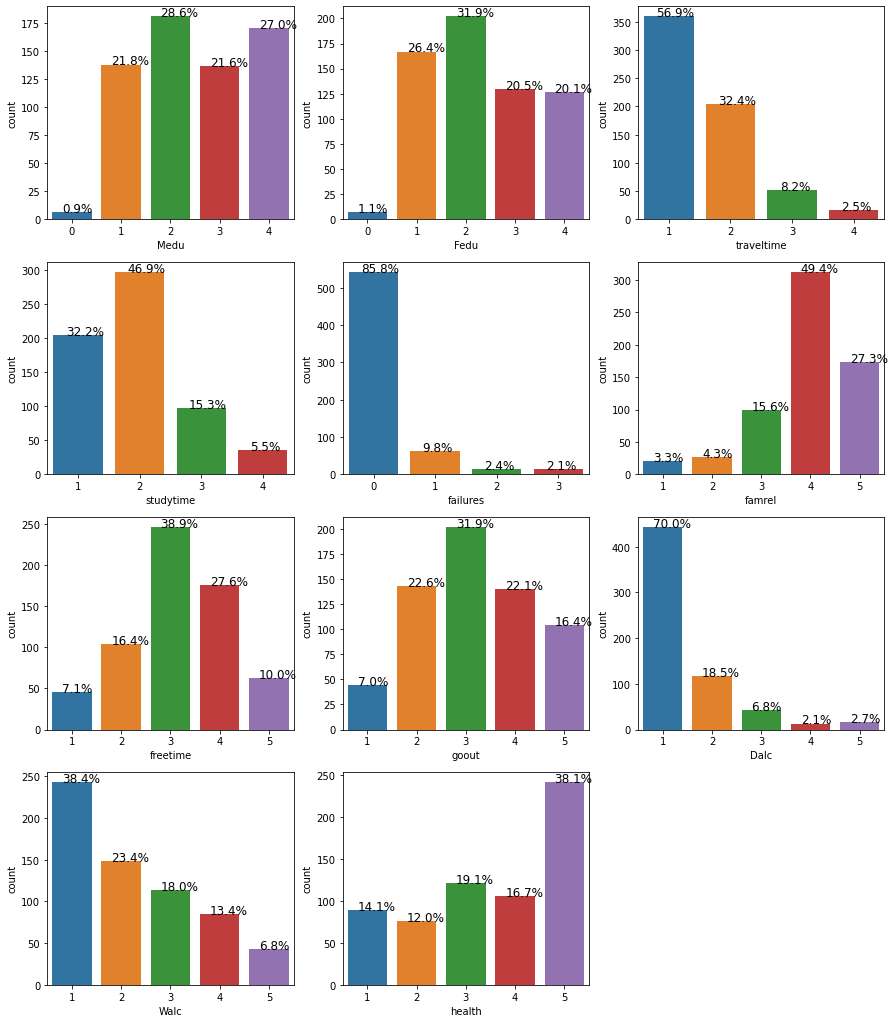

In [ ]:
#distribuzione ordinali
fig = plt.figure(figsize = (15,18))
g = gs.GridSpec(nrows = 4, ncols = 3, figure = fig)
i = 0
j = 0
for feature in ordin:
    if j == 3:
        i = i + 1
        j = 0
    ax1 = plt.subplot(g[i,j])
    ax1 = sns.countplot(df[feature])
    without_hue(ax1,df[feature])
    j = j + 1

Osservazioni:
- Medu e Fedu hanno una distribuzione equilibrata, con eccezione dei genitori con nessuna educazione. Infatti costituiscono solo l'% di tutti i genitori
- Più della metà degli studenti impiega meno di 15 minuti a raggiungere la scuola, il 33% ci impiega dai 15 ai 30 minuti, mentre il resto impiega più di 30 minuti
- Quasi la metà degli studenti(47%) studia da 2 a 5 ore a settimana, il 37% meno di 2 ore a settimana, il resto più di 5 ore a settimana
- La maggior parte degli studenti (85%) non ha mai fallito un corso. Il numero massimo di fallimenti in questo gruppo di studenti è 3(2,2%) 
- Quasi la metà degli studenti(49%) si trova bene con la famiglia, 28% si trova molto bene con la famiglia, il 16% abbastanza bene mentre il resto degli studenti no
- freetime e goout hanno una distribuzione normale.
- fortunatamente il consumo di alcool nei giorni feriali è minimo. Infatti circa il 70% degli studenti non consuma, oppure consuma pochissimo alcool nei giorni feriali
- nei weekend invece il consumo di alcool sale, ma rimane dominante il gruppo di studenti che consuma, oppure consuma poco alcool
- quasi il 40% degli studenti si trova in buona salute

### Distribuzione variabili nominali 

Analizziamo come sono distribuite le variabili qualitative nominali

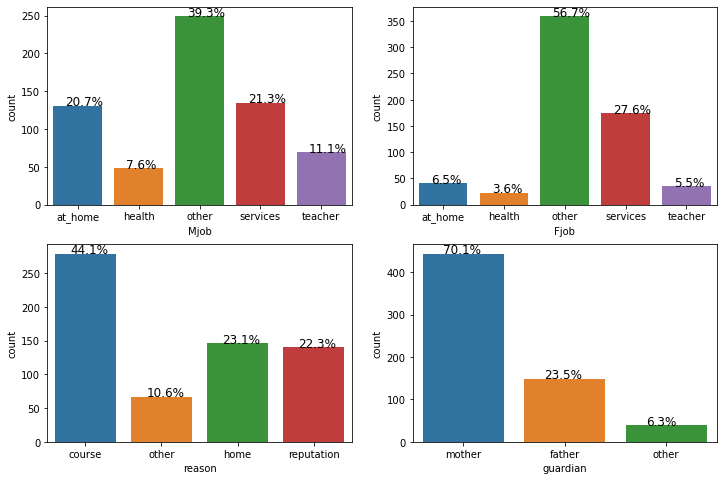

In [ ]:
#nom
fig = plt.figure(figsize = (12,8))
g = gs.GridSpec(nrows = 2, ncols = 2, figure = fig)

ax1 = plt.subplot(g[0,0])
ax1 = sns.countplot(df[nom[0]])
without_hue(ax1,df[nom[0]])

ax2 = plt.subplot(g[0,1])
ax2 = sns.countplot(df[nom[1]], order = ["at_home", "health", "other", "services", "teacher"])
without_hue(ax2,df[nom[1]])

ax3 = plt.subplot(g[1,0])
ax3 = sns.countplot(df[nom[2]])
without_hue(ax3,df[nom[2]])

ax4 = plt.subplot(g[1,1])
ax4 = sns.countplot(df[nom[3]])
without_hue(ax4,df[nom[3]])


Osservazioni:
- Lavoro della madre e del padre prevale "other"
- Il 44% degli studenti ha scelto la scuola per il corso di studi, altri perchè vicino a casa (23%), per la reputazione della scuola(22%) e una minoranza per altri motivi (11%)
- La maggior parte degli studenti(70%) è seguita dalla madre, 23,6% dal padre e 6,3% other

### Distribuzione variabili nominali binarie

Analizziamo come sono distribuite le variabili nominali binarie

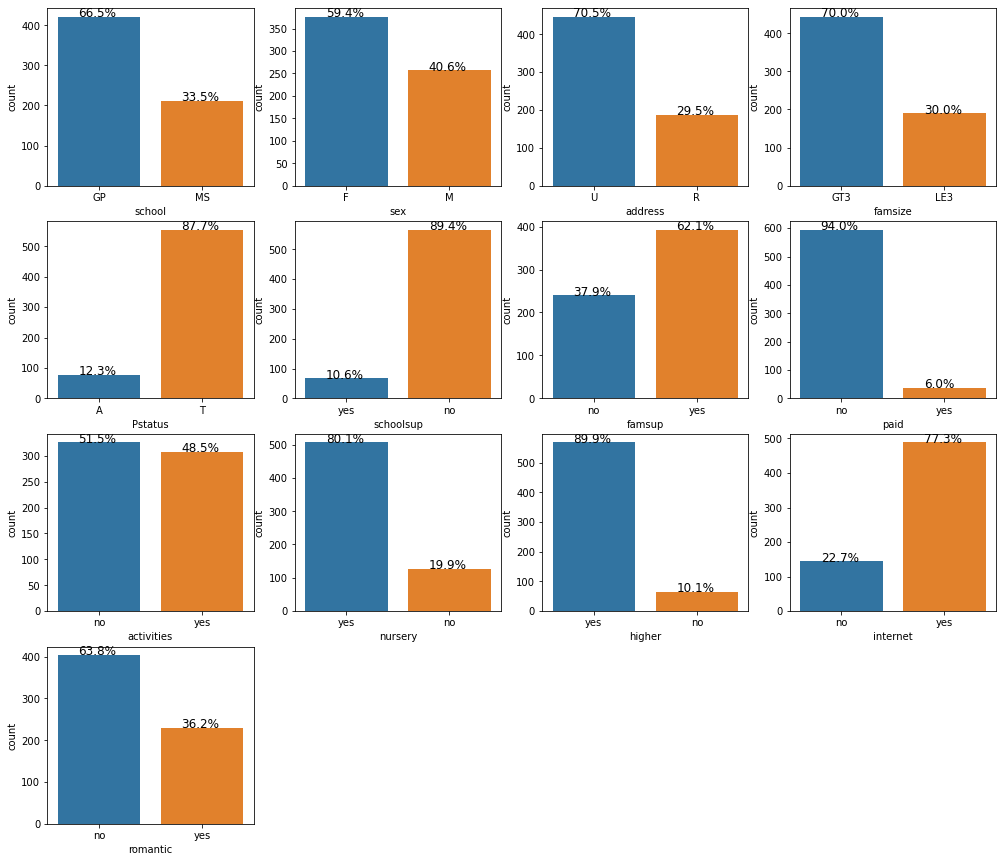

In [ ]:
#binary
fig = plt.figure(figsize = (17,15))
g = gs.GridSpec(nrows = 4, ncols = 4, figure = fig)
i = 0
j = 0
for feature in binary:
    if j == 4:
        i = i + 1
        j = 0
    ax1 = plt.subplot(g[i,j])
    ax1 = sns.countplot(df[feature])
    without_hue(ax1,df[feature])
    j = j + 1

Osservazioni:
- Sono presenti più femmine che maschi
- tutte le variabili sono sbilanciate verso un valore rispetto all'altro, eccetto la variabile "activities"

## Relazioni tra le variabili

Ora andiamo ad analizzare se sono presenti relazioni tra le variabili. Le analizzeremo in base al loro tipo, in modo da utilizzare la corretta misura di associazione.

### Relazione tra variabili continue

Iniziamo analizzando le relazioni tra le variabili continue. Per misurare la loro correlazione, utilizzeremo il coefficiente di correlazione di Pearson.

Text(0.5, 1.0, 'Continue - Continue')

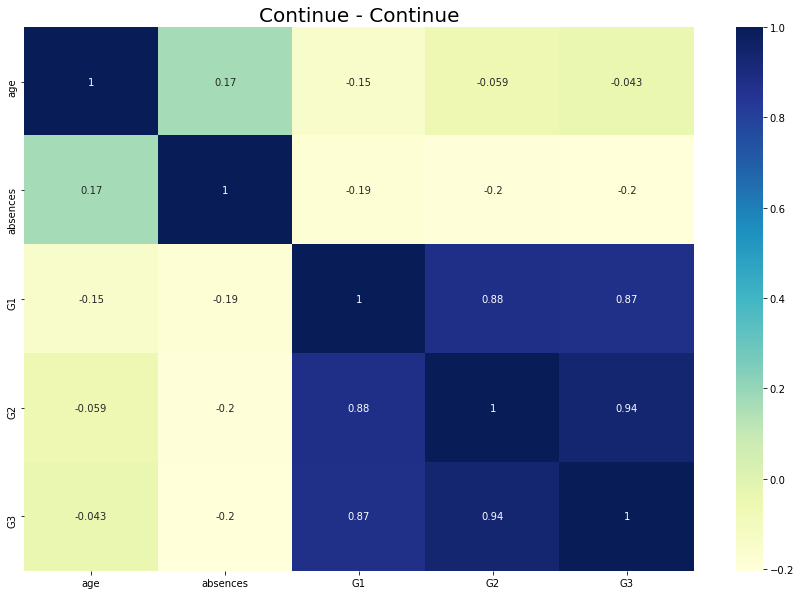

In [ ]:
#correlazione tra le continue e continue
fig = plt.figure(figsize = (15,10))
sns.heatmap(df[cont].corr(method = "pearson"), cmap="YlGnBu", annot = True)
plt.title("Continue - Continue", size = 20)

Si tratta di relazioni lineari, quindi le relazioni non-lineari non vengono catturate da questo test.

#### Osservazioni:
- Osserviamo una forte correlazione positiva tra i 3 voti G1, G2, G3. Ciò significa che all'aumentare di G1, aumentano anche G2 e G3.
- Possiamo notare una debole correlazione positiva tra età e assenze. Ciò vuol dire che all'aumentare dell'età, aumentano in modo debole le assenze
- E' presente anche una debole correlazione negativa tra età,assenze rispetto ai voti G1, G2, G3. Ciò significa che all'aumentare dell'età, o assenze i voti si abbassano

Visualizziamo la correlazione tra i voti utilizzando lo scatterplot

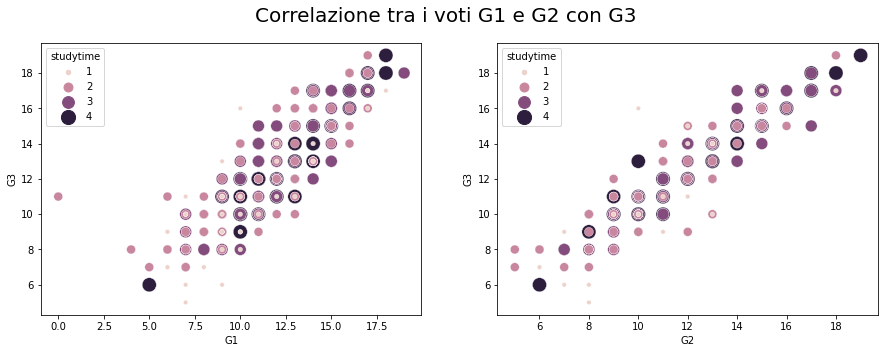

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.suptitle("Correlazione tra i voti G1 e G2 con G3", size = 20)
g = gs.GridSpec(nrows = 1, ncols = 2, figure = fig)

ax1 = plt.subplot(g[0,0])
ax1 = sns.scatterplot(data = df, x = df["G1"], y = df["G3"], size = df["studytime"], sizes=(20, 200),  hue=df["studytime"])

ax2 = plt.subplot(g[0,1])
ax2 = sns.scatterplot(data = df, x = df["G2"], y = df["G3"], size = df["studytime"], sizes=(20, 200),   hue=df["studytime"])


Notiamo dai 2 grafici che all'aumentare di G1 e G2, G3 aumenta

### Relazione tra variabili ordinali

Analizziamo le relazioni tra le variabili qualitative ordinali. Come misura utilizzo Spearman rank correlation coefficient

Text(0.5, 1.0, 'Ordinali - Ordinali')

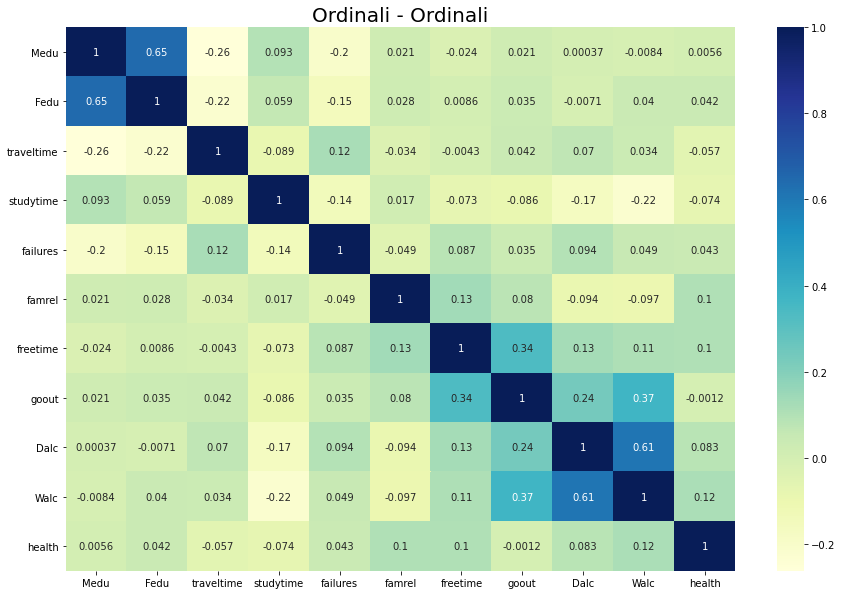

In [ ]:
#ordinale e ordinale
fig = plt.figure(figsize = (15,10))
sns.heatmap(df[ordin].corr(method = "spearman"), cmap="YlGnBu", annot = True)
plt.title("Ordinali - Ordinali", size = 20)

#### Osservazioni
Correlazioni positive:
- "Medu" e "Fedu" hanno una forte correlazione positiva(0.65). Possiamo dire che quindi i genitori tendono ad avere lo stesso livello di educazione
- "Dalc" e "Walc" hanno una forte correlazione positiva(0.61). Ciò significa che un alto consumo di alcool nei giorni feriali porta a un alto consumo di alcool nei weekend
- "Walc" è correlata in modo moderato a "goout"(0.37). Possiamo dire che chi va fuori con gli amici tende a bere alcool.
- "goout" e "freetime" sono moderatamente correlate(0.34). Quindi la frequenza con cui uno studente va fuori con gli amici dipende dall'ammontare di tempo libero

Correlazioni negative:
- "Walc" e "study time" hanno una moderata correlazione negativa(-0.22). Quindi chi dedica più tempo allo studio beve meno alcoolnei weekend
- "Medu" e "Fedu" hanno una moderata correlazione negativa con "traveltime". Se la coppia di genitori ha un livello di educazione elevato, lo studente si trova più vicino alla scuola
- "Medu" e "Fedu" hanno una moedrata correlazione negativa con "failures". Se i genitori dello studente hanno un alto livello di educazione, lo studente tende a fallire di meno nel suo corso.

### Relazioni tra variabili continue e variabili ordinali

Analizziamo ora le relazioni tra le variabili quantitative e le variabili qualitative ordinali. Per misurare le relazioni, utilizzo Kendall’s coefficient of rank correlation e Spearman rank correlation coefficient

Text(0.5, 0.98, 'Continue - Ordinali')

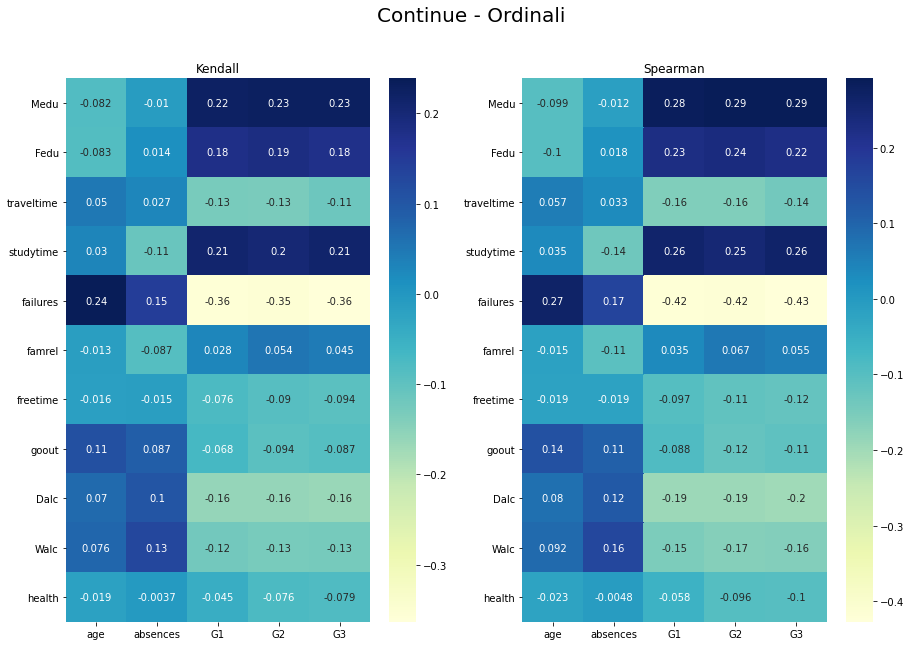

In [ ]:
#continue e ordinali
fig = plt.figure(figsize = (15,10))
g = gs.GridSpec(ncols = 2, nrows = 1, figure = fig)

ax1 = plt.subplot(g[0,0])
ax1 = sns.heatmap(df[ordin + cont].corr(method = "kendall")[cont].drop(cont), cmap="YlGnBu", annot = True)
plt.title("Kendall")

ax2 = plt.subplot(g[0,1])
ax2 = sns.heatmap(df[ordin + cont].corr(method = "spearman")[cont].drop(cont), cmap="YlGnBu", annot = True)
plt.title("Spearman")


plt.suptitle("Continue - Ordinali", size = 20)

#### Osservazioni
Correlazioni positive:
- "Medu" e Fedu" hanno una debole correlazione con i voti G1, G2 e G3. Questo ci dice che all'aumentare del livello dell'istruzione dei genitori, aumentano i voti dello studente
- "studytime" ha una debole correlazione positiva con i voti G1,G2 e G3. Questa correlazione è abbastanza "ovvia", e ci dice che all'aumentare delle ore di studio settimanali, aumetano i voti dello studente.
- "failures" è correlata moderatamente con "age". Possiamo dire che gli studenti più grandi tendono ad avere più fallimenti rispetto ai più giovani.

Correlazioni negative:
- "failures" ha una moderata correlazione negativa con i voti G1, G2 e G3. Anche questa è una correlazione abbastanza "ovvia", in quanto uno studente con voti alti tende ad avere meno fallimenti.
- "Dalc", "Walc" e "traveltime" hanno una debole correlazione negativa con i voti G1,G2,G3. 

### Come Medu, studytime e failures sono associate con G3

Andiamo ora a visualizzare le variabili con correlazione > 0.2 o < -0.2

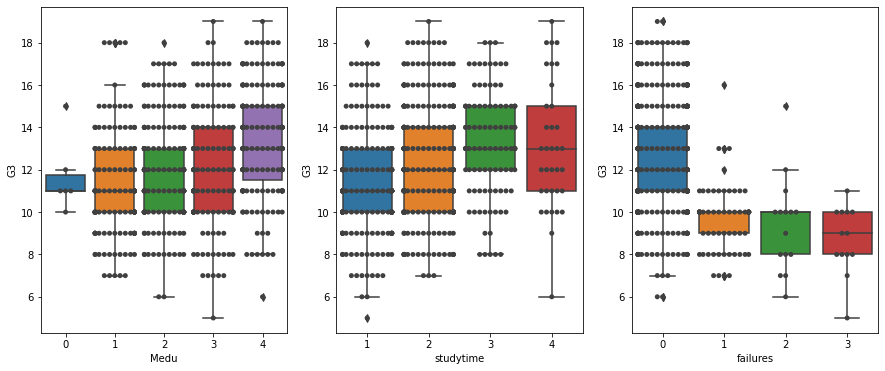

In [ ]:
##Visual delle variabili con corr > 0.25
caratt = ["Medu", "studytime", "failures"]
j = 0
fig = plt.figure(figsize = (15,6))
g = gs.GridSpec(nrows = 1, ncols = 3, figure = fig)

for feat in caratt:
    ax = plt.subplot(g[0,j])
    ax = sns.boxplot(data = df, x = df[feat], y = df["G3"])
    ax = sns.swarmplot(data = df, x = df[feat], y = df["G3"], color = ".25")
    j = j+1

In [ ]:
"""
puoi usare l'argomento "alpha" di swarmplot per rendere i punti trasparenti, "hue" per
colorarli
"""

'\npuoi usare l\'argomento "alpha" di swarmplot per rendere i punti trasparenti, "hue" per\ncolorarli\n'

#### Osservazioni:
- Notiamo come la mediana di G3 aumenta nel caso di correlazione positiva con Medu e studytime. Lo vediamo nei primi 2 grafici
- La mediana di G3 nel caso di correlazione negativa con failures diminuisce

### Come Medu e Fedu influiscono sui voti finali

Text(0.5, 1.0, 'Fedu - G3')

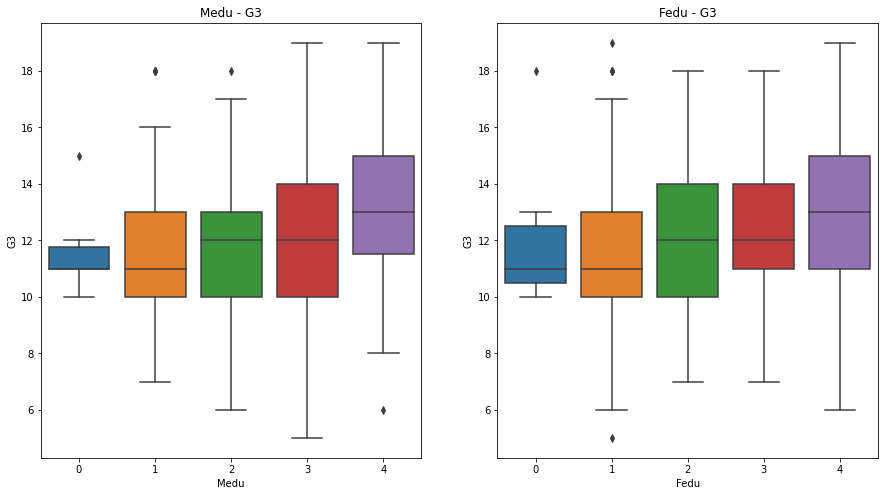

In [ ]:
fig = plt.figure(figsize = (15,8))
g = gs.GridSpec(nrows = 1, ncols = 2, figure = fig)

ax = plt.subplot(g[0,0])
ax = sns.boxplot(data = df, x = df["Medu"], y = df["G3"])
plt.title("Medu - G3")

ax2 = plt.subplot(g[0,1])
ax2 = sns.boxplot(data = df, x = df["Fedu"], y = df["G3"])
plt.title("Fedu - G3")

Notiamo come i voti crescono all'aumentare del livello di educazione dei genitori

### Come il consumo di alcool influisce sui voti finali

Text(0.5, 1.0, 'Walc - G3')

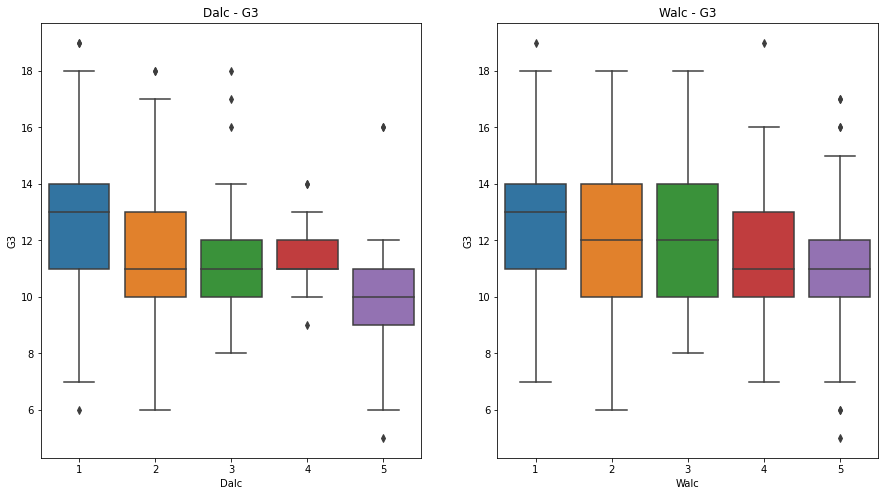

In [ ]:
fig = plt.figure(figsize = (15,8))
g = gs.GridSpec(nrows = 1, ncols = 2, figure = fig)

ax = plt.subplot(g[0,0])
ax = sns.boxplot(data = df, x = df["Dalc"], y = df["G3"])
plt.title("Dalc - G3")

ax2 = plt.subplot(g[0,1])
ax2 = sns.boxplot(data = df, x = df["Walc"], y = df["G3"])
plt.title("Walc - G3")

Notiamo che in entrambi casi all'aumentare del consumo di alcool, i voti tendono a diminuire

### Converto i valori delle variabili nominali binarie in 0 e 1 

In [ ]:
le = LabelEncoder()
for feature in binary:
    df[feature] = le.fit_transform(df[feature])
    print(feature, le.classes_)

school ['GP' 'MS']
sex ['F' 'M']
address ['R' 'U']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
schoolsup ['no' 'yes']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['no' 'yes']
higher ['no' 'yes']
internet ['no' 'yes']
romantic ['no' 'yes']


Il primo valore di ogni variabile sarà indicato con 0, il secondo con 1

### Relazione tra variabili continue e variabili nominali binarie

Analizziamo le relazioni tra le variabili quantitative e le variabili nominali binarie. Per misurare la relazione utilizzo point-biserial correlation coefficient. 

In [ ]:
#continue e binary
scores = []
li = []

print("point-biserial correlation > |0.15|")
for feat_bin in binary:
    for feat_cont in cont:
        corr = stats.pointbiserialr(df[feat_bin], df[feat_cont])[0]
        scores.append(corr)
        if corr >0.15 or corr < -0.15:
            print(feat_bin, feat_cont, corr)
            string1 = feat_bin + "-" + feat_cont
            tu = (string1, corr)
            li.append(tu)



point-biserial correlation > |0.15|
school G1 -0.2570367516671498
school G2 -0.2145497473237346
school G3 -0.22763152075038445
schoolsup age -0.16621614617076466
higher age -0.2500974229710962
higher G1 0.3465190058269606
higher G2 0.3239320554450534
higher G3 0.34374220062593347
romantic age 0.17625250743524717


### Visualizziamo le correlazioni più forti

<AxesSubplot:>

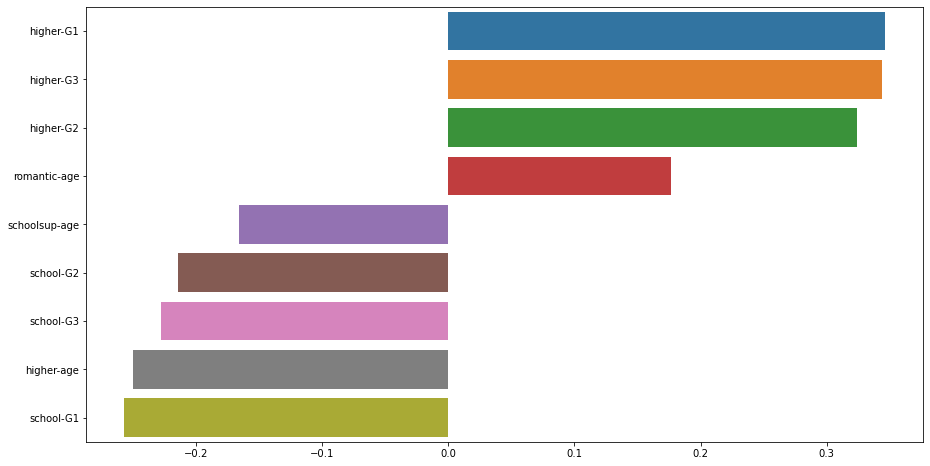

In [ ]:
li.sort(key=lambda tup: tup[1], reverse = True) 
name_li = [i[0] for i in li]
corr_li = [i[1] for i in li]
fig = plt.figure(figsize = (15,8))
sns.barplot(x = corr_li, y = name_li)

### Heatmap point-biserial correlation coefficient

Text(0.5, 1.0, 'Continue - Binary')

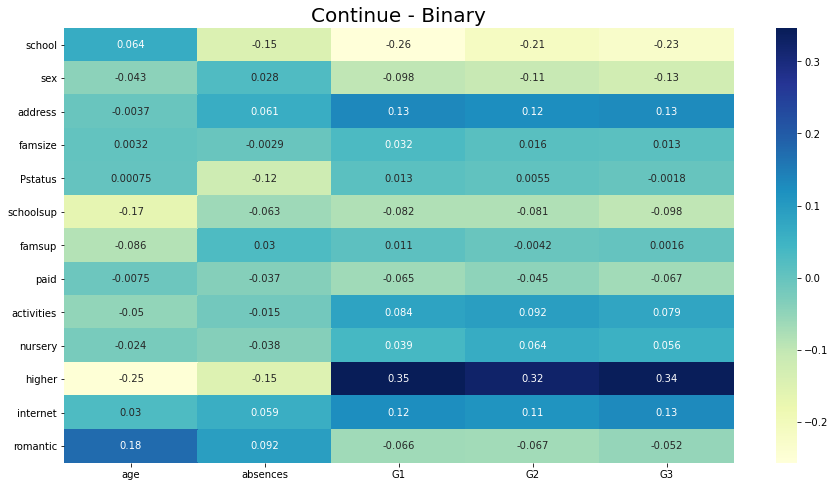

In [ ]:
scores = np.array(scores).reshape(len(binary), len(cont))
fig = plt.figure(figsize = (15,8))
sns.heatmap(scores, xticklabels = cont, yticklabels = binary, annot = True, cmap="YlGnBu")
plt.title("Continue - Binary", size = 20)

#### Osservazioni:
Trattandosi di variabili nominali non ordinali, non possiamo dire che una variabile nominale sia correlata positivamente o negativamente con una variabile continua. Da questi dati però possiamo notare che:
- Gli studenti della scuola "GP" tendono ad avere voti più alti rispetto agli studenti dell'altra scuola. 
- Gli studenti che desiderano continuare i propri studi tendono ad avere un età più bassa
- Gli studenti che vogliono continuare i propri studi tendono ad avere dei voti più alti

Visualizziamo le 4 correlazioni con G3.

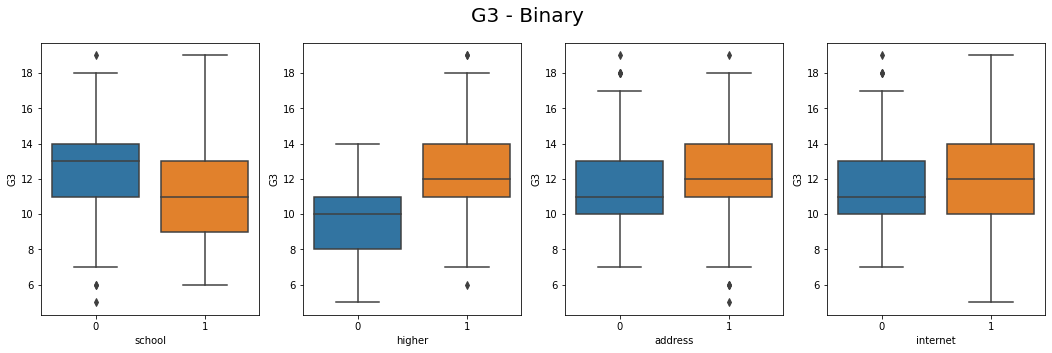

In [ ]:
##visual le più importanti con g3
caratt = ["school", "higher","address", "internet"]
fig = plt.figure(figsize = (18,5))
g = gs.GridSpec(nrows = 1, ncols = 4, figure = fig)
plt.suptitle("G3 - Binary", size = 20)

j = 0
for feat in caratt:
    ax = plt.subplot(g[0,j])
    ax = sns.boxplot(data = df, x = df[feat], y = df["G3"])
    j = j+1

Nei casi in cui la correlazione con G3 in valore assoluto("higher" e "school") è maggiore, aumenta la differenza di distribuzione di G3 per ogni valore della variabile binaria.

### Come higher influenza il voto finale in base alla scuola

<AxesSubplot:xlabel='higher', ylabel='G3'>

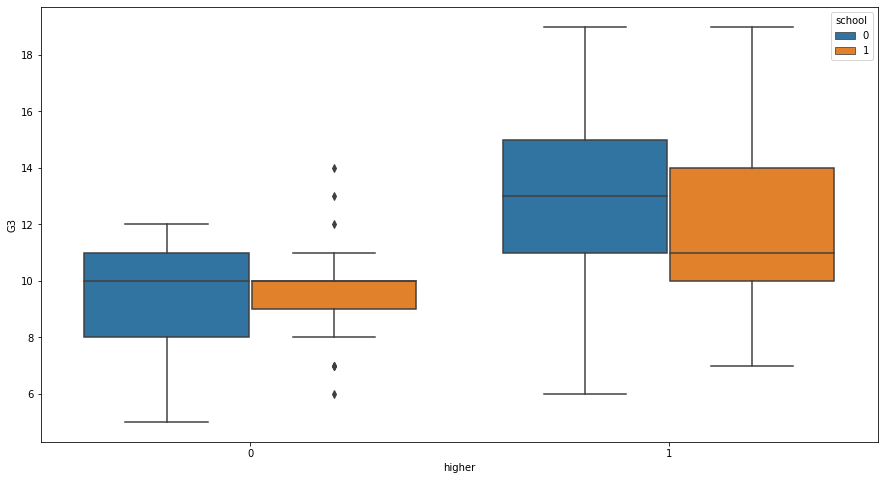

In [ ]:
fig = plt.figure(figsize = (15,8))
sns.boxplot(data = df, x = df["higher"], y = df["G3"], hue = df["school"])

### Relazione tra variabili continue e nominali

Analizziamo le relazioni tra variabili conitnue e variabili nominali con più di 2 valori unici. Per misurare la relazione utilizzo eta-squared

In [ ]:
## variabili continue e nominali
scores = []
print("Eta-square > |0.15|")
for feature in nom:
        for var in cont:
            corr = correlation_ratio(df[feature], df[var])
            scores.append(corr)
            if corr >0.15:
                print(feature, var, corr)

Eta-square > |0.15|
Mjob G1 0.24303719917104252
Mjob G2 0.21937990644972258
Mjob G3 0.23559113830216016
Fjob G1 0.18575172317141309
Fjob G2 0.18413326549143777
Fjob G3 0.17005636749302075
reason G1 0.2077958728242717
reason G2 0.21848125182530104
reason G3 0.21649190883733901
guardian age 0.3462064259292172
guardian absences 0.17512124120767109


### Heatmap eta-squared

Text(0.5, 1.0, 'Continue - Nominali')

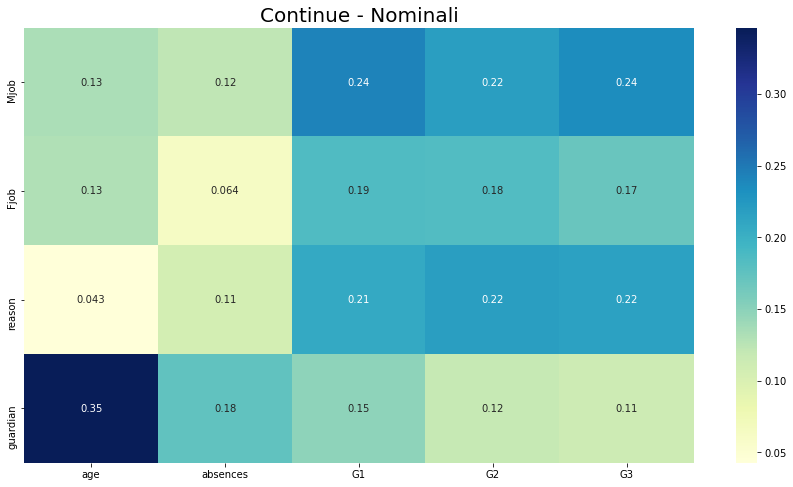

In [ ]:
scores = np.array(scores).reshape(len(nom), len(cont))
fig = plt.figure(figsize = (15,8))
sns.heatmap(scores, xticklabels = cont, yticklabels = nom, annot = True, cmap="YlGnBu")

plt.title("Continue - Nominali", size = 20)

#### Osservazioni:
- Notiamo delle deboli associazioni tra i voti con "Mjob", "Fjob, e "reason". Ciò significa che dato un voto, abbiamo una debole possibilità di riconoscere il valore di"Mjob", "Fjob" e "reason".


Visualizziamo le associazioni di "Mjob, "Fjob" e "reason" con G3.

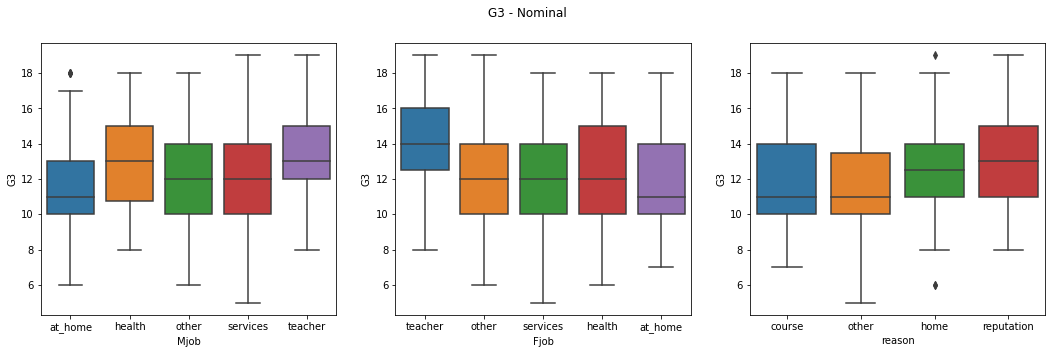

In [ ]:
##visual per g3
caratt = ["Mjob", "Fjob", "reason"]
fig = plt.figure(figsize = (18,5))
g = gs.GridSpec(nrows = 1, ncols = 3, figure = fig)
plt.suptitle("G3 - Nominal")
j = 0
for feat in caratt:
    ax = plt.subplot(g[0,j])
    ax = sns.boxplot(data = df, x = df[feat], y = df["G3"])
    j = j+1

Osservazioni:
- possiamo notare la differenza di distribuzione di G3 in base ai valori delle variabili nominali.
- Gli studenti con madre che lavora in "health" e "teacher" tendono ad avere dei voti più alti
- Gli studenti con padre che lavora in "teacher" tendono ad avere voti maggiori
- Gli studenti che hanno scelto la scuola per la sua reputazioni tendono ad avere voti più alti.

### Relazione tra variabili nominali

Analizziamo le relazioni tra variabili nominali. Per misurare la relazione, utilizziamo la V di Cramer.

In [ ]:
#nominale contro nominale
#uso chi quadrato      
nom_bin = nom + binary
li = []
scores = []
print("Cramers_v > |0.20|")
for feat in nom_bin:
    for feat2 in nom_bin:
        pres = True
        corr = cramers_v(df[feat], df[feat2])
        scores.append(corr)
        tu = (feat, feat2)
        if tu in li:
            pres = False
        else:
            tu2 = (feat2, feat)
            li.append(tu2)
        if corr > 0.20:
            if feat != feat2:
                if pres == True:
                    print(feat, feat2, corr)



Cramers_v > |0.20|
Mjob Fjob 0.21812330555302503
Mjob school 0.2272284194338807
Mjob internet 0.2799949174996614
reason school 0.2736617598626694
school address 0.33445372154856184
school internet 0.22239161246300443
famsize Pstatus 0.22836234058781854


### Heatmap Cramer's V

Text(0.5, 1.0, 'Nominali - Nominali')

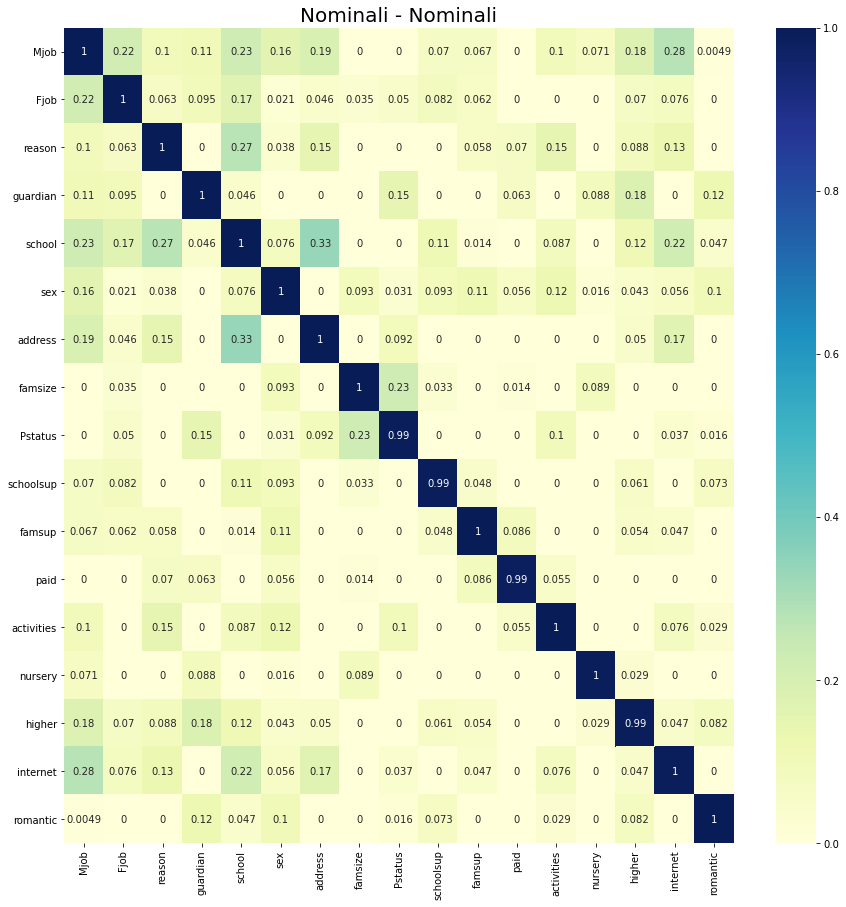

In [ ]:
scores = np.array(scores).reshape(len(nom_bin), len(nom_bin))
fig = plt.figure(figsize = (15,15))
sns.heatmap(scores, xticklabels = nom_bin, yticklabels = nom_bin, annot = True, cmap="YlGnBu")
plt.title("Nominali - Nominali", size = 20)

Questi valori misurano il livello di associazioni tra le nostre variabili qualitative. Non ci dicono molto e queste informazioni non sono utili per il nostro scopo.

### Relazione tra variabili binarie e variabili ordinali

Per misurare la relazione, utilizzo Spearman rank-order correlation

In [ ]:
li_temp = []
li_temp2 = []
scores = []
print("Spearman rank-order correlation > |0.20|")
for feat_bin in binary:
    for feat_cont in ordin:
        corr = stats.spearmanr(df[feat_bin], df[feat_cont])[0]
        scores.append(corr)
        if corr >0.20 or corr < -0.20:
            print(feat_bin, feat_cont, corr)
            li_temp.append(feat_bin)
            li_temp2.append(feat_cont)

Spearman rank-order correlation > |0.20|
school Medu -0.26211128500252
school Fedu -0.20189254005525803
school traveltime 0.28095520809983454
sex studytime -0.2286416730224739
sex Dalc 0.27645017668003424
sex Walc 0.29055787925729626
address Medu 0.20100379373808114
address traveltime -0.3415719821136436
higher Medu 0.2054463576079943
higher failures -0.28766307329574736
internet Medu 0.2584688440932315


### Heatmap Spearman rank-order correlation

<AxesSubplot:>

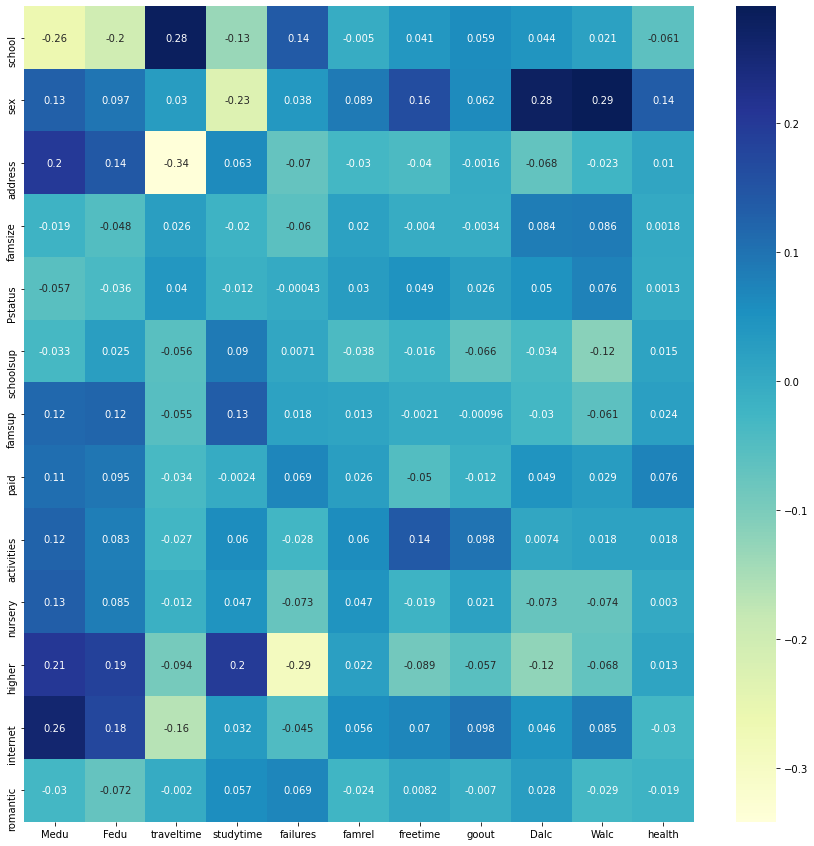

In [ ]:
scores = np.array(scores).reshape(len(binary), len(ordin))
fig = plt.figure(figsize = (15,15))
sns.heatmap(scores, xticklabels = ordin, yticklabels = binary, annot = True, cmap="YlGnBu")

#### Osservazioni:
- La correlazione di "school" con "Medu" e "Fedu" è moderata. Gli studenti di "MS" tendono ad avere genitori con un livello di educazione più basso
- Gli studenti che vanno nella scuola "MS" tendono ad avere un viaggio per andare a scuola più lungo
- I maschi tendono a studiare meno ore settimanali rispetto alle femmine
- "sex" ha una moderata correlazione positiva con Dalc e Walc. Possiamo dire che gli studenti maschi tendono a consumare più alcool rispetto alle femmine
- "address" e "traveltime" hanno una correlazione negativa moderata. Infatti possiamo dire che chi viene dalle zone urbane tende ad avere un viaggio verso scuola più corto.
- "higher" ha una correlazione moderata con "Medu", "studytime" e "failures. Da questi possiamo dire che gli studenti che pensano di continuare gli studi tendono ad avere una madre con un livello di educazione elevato, passano più ore a studiare e hanno meno fallimenti.
- notiamo che gli studenti che hanno una madre con un livello di educazione elevato, tendono ad avere internet

### Relazione tra variabili nominali e variabili ordinali

Per misurare la relazione utilizziamo eta quadro

In [ ]:
scores = []
print("Eta square > 0.20")
for var in ordin:
        for feature in nom:
            corr = correlation_ratio(df[feature], df[var])
            scores.append(corr)
            if corr >0.20:
                print(feature, var, corr)


Eta square > 0.20
Mjob Medu 0.6302848352922928
Fjob Medu 0.3163203552469871
Mjob Fedu 0.413047746849146
Fjob Fedu 0.4407334150521074
Mjob traveltime 0.20901733472622422
guardian failures 0.22580845124070828


### Heatmap eta squared

Text(0.5, 1.0, 'Nominali - Ordinali')

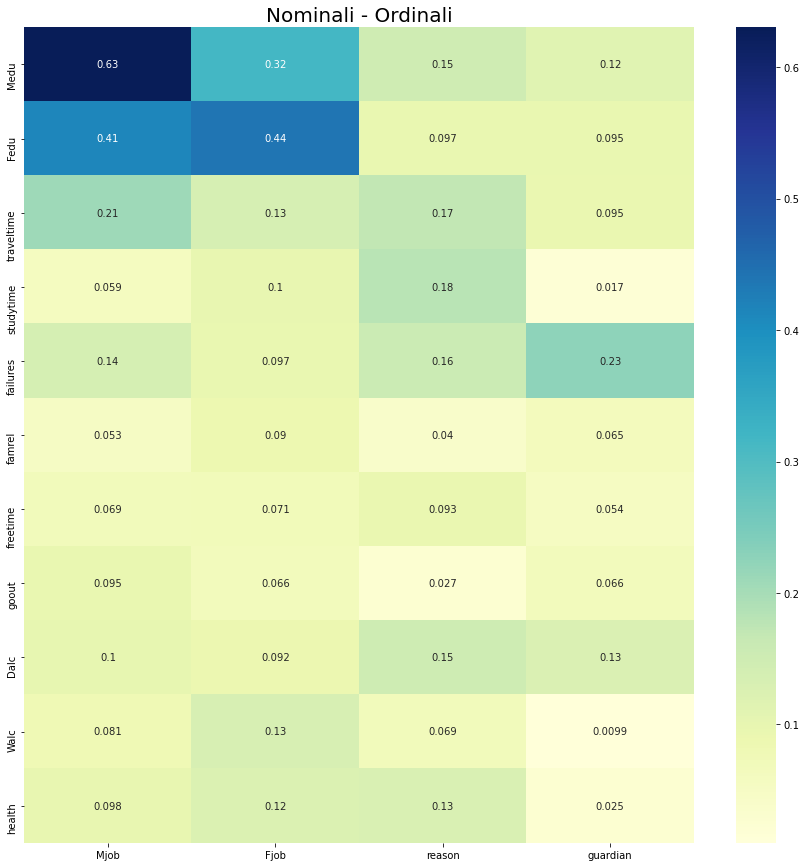

In [ ]:
scores = np.array(scores).reshape(len(ordin), len(nom))
fig = plt.figure(figsize = (15,15))
sns.heatmap(scores, xticklabels = nom, yticklabels = ordin, annot = True, cmap="YlGnBu")
plt.title("Nominali - Ordinali", size = 20)

#### Osservazioni:
- Notiamo una forte associazione tra "Mjob" e "Medu", e "Fjob" e "Fedu". Quindi conoscendo il livello di educazione dei genitori è possibile riconoscere con moderata probabilità il lavoro dei genitori.
- "guardian" ha una debole associazione con "failures".

#### Relazione tra variabili nominali(trasformate con one hot encoding) e variabili continue

In [ ]:
data = pd.get_dummies(df)
nom_dumm = list(data.iloc[:,29:46].columns)

for feat_bin in nom_dumm:
    for feat_cont in cont:
        corr = stats.pointbiserialr(data[feat_bin], data[feat_cont])[0]
        if corr >0.15 or corr < -0.15:
            print(feat_bin, feat_cont, corr)



Mjob_at_home G1 -0.18187082656264522
Mjob_at_home G3 -0.15849647906708747
Mjob_teacher G1 0.16109313580538176
Mjob_teacher G2 0.1591719395497877
Mjob_teacher G3 0.17385098131590626
Fjob_teacher G1 0.15565300506777596
Fjob_teacher G2 0.167080723593151
Fjob_teacher G3 0.16093825288966845
reason_course G1 -0.1526594875778612
reason_reputation G1 0.1783867240179879
reason_reputation G2 0.19550188212359365
reason_reputation G3 0.1859793703061866
guardian_other age 0.33284030095361733
guardian_other absences 0.15878784448336894


#### Osservazioni:
- Se la madre sta a casa, i voti G1 e G2 tendono a diminuire leggermente
- Gli studenti che hanno scelto la scuola perla sua reputazione, hanno dei voti leggermente più alti
- Gli studenti che hanno un età grande tendono a non avere padre o madre come guardian.


# 2 - Predizione voto finale G3 <a class="anchor" id="third-bullet"></a>

## Preparo i dati

Il nostro scopo è quello di addestrare il modello utilizzando le features che descrivono la situazione personale e sociale. Per questo motivo togliamo dalle features tutte le variabili collegate alla carriera dello studente, che sono:
- G1
- G2
- failures
- absences
- school

### Features e Labels, converto Data in Arrays




In [ ]:
labels = data["G3"]
data.drop(["G1", "G2", "G3", "failures", "absences", "school"], inplace= True, axis = 1)
features = data

feature_list = list(features.columns)
features = np.array(features)
labels = np.array(labels)



Divido il dataset in features e target, dove il target è "G3". 

### Train Test split

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)


diz_performance_train = {}
diz_performance_test = {}

Divido il dataset in 2, training set e test set.

### Feature Scaling

Notiamo che i valori min max delle variabili sono molto diversi tra loro. Visto che andremo a creare un modello SVR, applichiamo la normalizzazione MinMaxScaler alle nostre osservazioni

In [ ]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)


### Metriche di valutazione

Per valutare la performance del modello, utilizzo 4 metriche di valutazione:
- R-square/Adjusted R-square, per misurare quanto la variabilità del target può essere spiegata dal modello
- Mean Square Error(MSE), per misurare la bontà del modello. MSE misura quanto le predizioni del modello deviano dal target. Dato che eleva al quadrato queste differenze, MSE penalizza molto gli errori
- Mean Absolute Error(MAE), per misurare la bontà del modello. A differenza di MSE, che penalizza i grandi errori, MAE gestisce gli errori in modo equo. Quindi è più robusta agli outliers a differenza di MSE.

R-square ha valori da 0 a 1. Ci servirà per spiegare la variabilità di G3 in percentuale. Più è alto R-square migliore è la performance del moedllo. Il problema di R Square è che aumenta all'aumentare del numero delle features, quindi potrebbe non essere completamente affidabile. Per evitare ciò, utilizziamo anche Adjusted R-square che non dipende dal numero delle features.

MSE e MAE li utilizzeremo per confrontare i vari modelli che andremo ad utilizzare. Più sarà basso l'errore, più alta sarà la bontà del modello.

MAE inoltre ha la stessa unità di misura del target.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Funzioni per visualizzare la performance del modello

In [ ]:
def get_metrics(features, labels, clf):
    pred = clf.predict(features)
    R2 = r2_score(labels, pred)
    MSE = mean_squared_error(labels, pred)
    MAE = mean_absolute_error(labels, pred)
    r2_adj = 1 - (1-R2)*(len(labels)-1)/(len(labels)-features.shape[1]-1)
    if r2_adj < 0:
        r2_adj = 0
    return (R2, r2_adj, MSE, MAE)

def metrics_print(metrics):
    
    print("R square = ", round(metrics[0], 3))
    print("R Square adj = ", round(metrics[1],3))
    print("MSE = ", round(metrics[2],3))
    print("MAE = ", round(metrics[3],3))


## Creazione Modello - Support Vector Regression
Support Vector Regression è un modello di apprendimento supervisionato che mira a ridurre l'errore determinando l'iperpiano e riducendo al minimo l'intervallo tra i valori previsti e quelli osservati.

#### GridSearchCV
La ricerca sulla griglia è una tecnica per l'ottimizzazione dell'iperparametro che può facilitare la creazione di un modello e valutare un modello per ogni combinazione di parametri.

Nel nostro caso, GridSearchCV sceglie la combinazione di iperparametri che ci dà l'errore assoluto più basso.

### Ottimizzazione Iperparametri
Utilizziamo GridSearchCV per ottimizzare gli iperparametri del modello SVR
Andremo a ottimizzare gli iperparametri in base al kernel che utilizziamo. 

I kernel sono delle funzioni matematiche. Il loro scopo è di prendere i dati come input e trasformarli nella forma richiesta qualora non sia possibile determinare un iperpiano linearmente separabile

Con kernel= "linear" andremo a ottimizzare:
- C: determina quanto penalizzare ogni punto classificato erroneamente
- epsilon: margine di tolleranza dove non viene penalizzato l'errore.

kernel = "rbf" ottimizziamo:
- C
- gamma: controlla la distanza dell'influenza di un singolo punto di addestramento.
- epsilon

Nota su C:

Se C è piccolo, la penalità per i punti classificati erroneamente è bassa, quindi viene scelto un confine di decisione con un ampio margine a spese di un numero maggiore di errori di classificazione.

Se C è grande, SVM cerca di ridurre al minimo il numero di esempi classificati erroneamente a causa dell'elevata penalità che si traduce in un confine decisionale con un margine inferiore. La sanzione non è la stessa per tutti gli esempi classificati male. È direttamente proporzionale alla distanza dal confine di decisione.








In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform

svr = SVR()
param = [{"kernel": ["linear"],"C": loguniform(1e-4, 1e3), "epsilon":loguniform(1e-4, 1e3)},
        {"kernel": ["rbf"], "C":loguniform(1e-4, 1e3), "gamma": loguniform(1e-4, 1e3), "epsilon": loguniform(1e-4, 1e3)}]

svr_best = RandomizedSearchCV(estimator = svr, param_distributions = param, n_iter = 500, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring= 'neg_mean_absolute_error', return_train_score = True)
svr_best.fit(features_train, labels_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=500, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029A45E33160>,
                                         'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029A483B8220>,
                                         'kernel': ['linear']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029A483B8460>,
                                         'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029A483B8940>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029A483B86A0>,
                                         'kernel': ['rbf']}],
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

### Parametri migliori

In [ ]:
svr_best.best_params_

{'C': 3.3221611050225404,
 'epsilon': 0.9895736731040692,
 'gamma': 0.031094034871722204,
 'kernel': 'rbf'}

### Risultati performance SVR 

In [ ]:
#Training set
print("Training set")
diz_performance_train["SVR"] = get_metrics(features_train, labels_train, svr_best)
metrics_print(diz_performance_train["SVR"])

print("\nTest set")
diz_performance_test["SVR"] = get_metrics(features_test, labels_test, svr_best)
metrics_print(diz_performance_test["SVR"])

Training set
R square =  0.342
R Square adj =  0.276
MSE =  4.649
MAE =  1.678

Test set
R square =  0.288
R Square adj =  0.097
MSE =  4.99
MAE =  1.808


Confrontiamo MAE di SVR con gli altri modelli

### Creazione modello - Decision Tree Regressor


Decision Tree è un algoritmo di apprendimento supervisionato, dove ogni nodo interno rappresenta una variabile, un arco verso un nodo figlio rappresenta un possibile valore per quella proprietà e una foglia il valore predetto per la variabile obiettivo a partire dai valori delle altre proprietà, che nell'albero è rappresentato dal cammino (path) dal nodo radice (root) al nodo foglia. 

### Ottimizzazione iperparametri

Anche per questo modello utilizzeremo GridSearchCV per ottimizzare gli iperparametri.

Andremo a ottimizzare 4 iperparametri:
- max_features: numero di features da considerare
- max_depth: massima profondità degli alberi
- min_samples_split: Il numero minimo di osservazioni richiesto per dividere un nodo interno
- min_samples_leaf: Il numero minimo di osservazioni richiesto per essere in un nodo foglia

In [ ]:
from sklearn.tree import DecisionTreeRegressor

max_features = [int(x) for x in np.arange(1, len(feature_list) + 1)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split =[0.2, 0.4, 0.6, 0.8, 1.0]
min_samples_leaf = [1, 2, 4, 10, 20, 40]


dt = DecisionTreeRegressor(random_state = 0)


param = {"max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf}

dt_best = GridSearchCV(dt, param, verbose = 2, n_jobs = -1, scoring= 'neg_mean_absolute_error')

dt_best.fit(features_train, labels_train)

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 7288 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 32888 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 69112 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 72000 out of 72000 | elapsed:   36.6s finished


GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'min_samples_leaf': [1, 2, 4, 10, 20, 40],
                         'min_samples_split': [0.2, 0.4, 0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

### Performance modello Decision Tree

In [ ]:
print("Training set")
diz_performance_train["decision_tree"] = get_metrics(features_train, labels_train, dt_best)
metrics_print(diz_performance_train["decision_tree"])

print("\nTest set")
diz_performance_test["decision_tree"] = get_metrics(features_test, labels_test, dt_best)
metrics_print(diz_performance_test["decision_tree"])

Training set
R square =  0.251
R Square adj =  0.177
MSE =  5.287
MAE =  1.834

Test set
R square =  0.138
R Square adj =  0
MSE =  6.048
MAE =  2.019


### Combinazione migliore di iperparametri

In [ ]:
dt_best.best_params_

{'max_depth': 10,
 'max_features': 40,
 'min_samples_leaf': 10,
 'min_samples_split': 0.2}

## Creazione modello - Random Forest Regressor

L’algoritmo Random Forest è un algoritmo di apprendimento supervisionato.

Rappresenta un tipo di modello ensemble, che si avvale del bagging come metodo di ensemble e decision tree come modello individuale.

Ciò significa che una foresta casuale combina molti alberi decisionali in un unico modello. Individualmente, le previsioni fatte dagli alberi decisionali potrebbero non essere accurate, ma combinate insieme, le previsioni saranno in media più vicine al risultato.

Nei Random Forest il bias del modello è uguale al bias del singolo albero decisionale(che ha alta varianza). Creando una foresta di alberi decisionali e combinandoli insieme, la varianza del modello finale può essere ridotta di molto rispetto a quella del singolo albero decisionale.

### Scelta Iperparametri

Per questo modello, utilizzeremo RandomizedGridSearchCV al posto di GridSearchCV per ottimizzare gli iperparametri. La differenza tra i 2 approcci è che in GridSearch addestriamo il modello con tutte le combinazioni possibili tra la griglia di iperparametri, mentre in RandomizedGridSearchCV il modello seleziona le combinazioni in modo casuale.

Andremo a ottimizzare 3 iperparametri:
- n_estimators: numero di alberi nella foresta
- max_features: numero di features da considerare
- min_samples_split: Il numero minimo di osservazioni richiesto per dividere un nodo interno

In [ ]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [1000]

max_features = [int(x) for x in np.arange(1, len(feature_list) + 1)]
min_samples_split = loguniform(1e-4, 1e0)


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split}


rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring= 'neg_mean_absolute_error')

rf_random.fit(features_train, labels_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029A48896F10>,
                                        'n_estimators': [1000]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

### Performance modello Random Forest

In [ ]:
print("Training set")
diz_performance_train["random_forest"] = get_metrics(features_train, labels_train, rf_random)
metrics_print(diz_performance_train["random_forest"])

print("\nTest set")
diz_performance_test["random_forest"] = get_metrics(features_test, labels_test, rf_random)
metrics_print(diz_performance_test["random_forest"])

Training set
R square =  0.891
R Square adj =  0.88
MSE =  0.771
MAE =  0.684

Test set
R square =  0.316
R Square adj =  0.132
MSE =  4.799
MAE =  1.774


### Combinazione di parametri  migliore

In [ ]:
rf_random.best_params_

{'max_features': 37,
 'min_samples_split': 0.001378357829479638,
 'n_estimators': 1000}

# Creazione modello - KNeighbors Regressor

Il k-nearest neighbors (k-NN) è un algoritmo utilizzato nel riconoscimento di pattern per la classificazione di oggetti basandosi sulle caratteristiche degli oggetti vicini a quello considerato. In entrambi i casi, l'input è costituito dai k esempi di addestramento più vicini nello spazio delle funzionalità

### Scelta iperparametri

Per questo modello andremo a validare 3 iperparametri:
- leaf_size: grandezza della foglia passato all'algoritmo BallTree o KdTree
- n_neighbors: numero di vicini da considerare 
- p: parametro per metrica di Minkoswki. Se p = 1, allora si usa manhattan distance, se p = 2 si utilizza euclidean distance

Per trovare la combinazione ottima di iperparametri, andremo a utilizzare GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

params = {"leaf_size": leaf_size, "n_neighbors":n_neighbors, "p":p}
knn = KNeighborsRegressor()
knn_best = GridSearchCV(knn, params, verbose = 3, n_jobs = -1, scoring= 'neg_mean_absolute_error')
knn_best.fit(features_train, labels_train)


Fitting 5 folds for each of 2842 candidates, totalling 14210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 14210 out of 14210 | elapsed:   29.0s finished


GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29],
                         'p': [1, 2]},
             scoring='neg_mean_absolute_error', verbose=3)

Utilizzando GridSearchCV proviamo un totale di 2842 combinazioni, e con cv = 5 si effettuano 14210 fits.

### Performance modello KNN

In [ ]:
print("Training set")
diz_performance_train["knn"] = get_metrics(features_train, labels_train, knn_best)
metrics_print(diz_performance_train["knn"])

print("\nTest set")
diz_performance_test["knn"] = get_metrics(features_test, labels_test, knn_best)
metrics_print(diz_performance_test["knn"])

Training set
R square =  0.224
R Square adj =  0.147
MSE =  5.479
MAE =  1.877

Test set
R square =  0.21
R Square adj =  0
MSE =  5.541
MAE =  1.904


### Combinazione di parametri migliore

In [ ]:
knn_best.best_params_

{'leaf_size': 2, 'n_neighbors': 17, 'p': 1}

### Visualizziamo l'errore dei 4 modelli
Confrontiamo l'errore commesso tra i modelli. Dato che stiamo utilizzando dei modelli non lineari non teniamo conto di R-square e Adjusted R-square

In [ ]:
mse_val_test = [diz_performance_test[i][2] for i in diz_performance_test]
mae_val_test = [diz_performance_test[i][3] for i in diz_performance_test]

mse_val_train = [diz_performance_train[i][2] for i in diz_performance_train]
mae_val_train = [diz_performance_train[i][3] for i in diz_performance_train]

modelli = list(diz_performance_test.keys())


Text(0.5, 1.0, 'MAE - Test set')

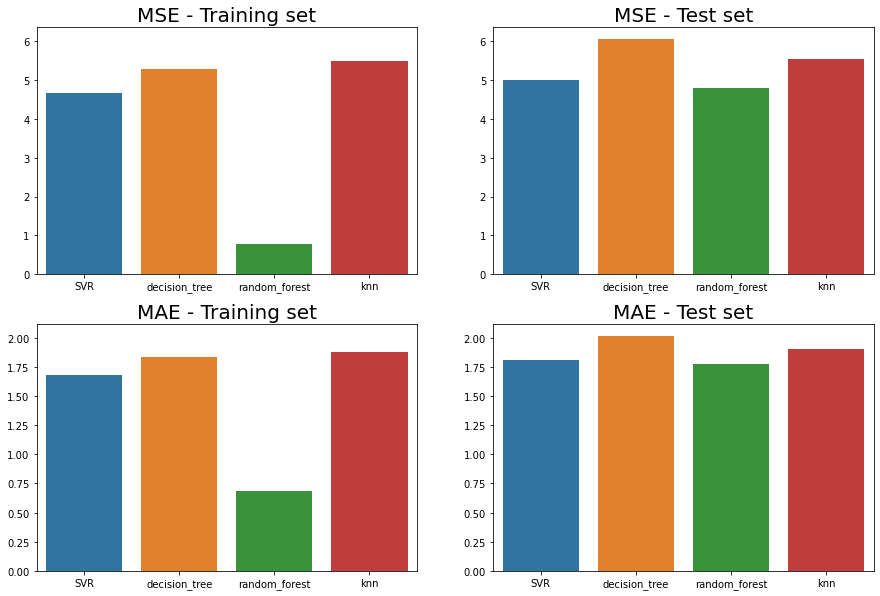

In [ ]:
fig = plt.figure(figsize = (15,10))
g = gs.GridSpec(nrows = 2, ncols = 2, figure = fig)

ax1 = plt.subplot(g[0,0])
ax1 = sns.barplot(x = modelli, y = mse_val_train)
plt.title("MSE - Training set", size = 20)

ax2 = plt.subplot(g[0,1], sharey = ax1)
ax2 = sns.barplot(x = modelli, y = mse_val_test)
plt.title("MSE - Test set", size = 20)

ax3 = plt.subplot(g[1,0])
ax3 = sns.barplot(x = modelli, y = mae_val_train)
plt.title("MAE - Training set", size = 20)

ax4 = plt.subplot(g[1,1], sharey = ax3)
ax4 = sns.barplot(x = modelli, y = mae_val_test)
plt.title("MAE - Test set", size = 20)


Osservazioni:
- notiamo che sia MAE e MSE aumenta su Test set
- SVR e Random Forest hanno ottenuto MAE e MSE più bassi sia su Training set sia su Test set

### Riassunto Performance dei modelli migliorati su test set

In [ ]:
for model in diz_performance_test:
    print(model)
    metrics_print(diz_performance_test[model])
    print("\n")

SVR
R square =  0.288
R Square adj =  0.097
MSE =  4.99
MAE =  1.808


decision_tree
R square =  0.138
R Square adj =  0
MSE =  6.048
MAE =  2.019


random_forest
R square =  0.316
R Square adj =  0.132
MSE =  4.799
MAE =  1.774


knn
R square =  0.21
R Square adj =  0
MSE =  5.541
MAE =  1.904




### Confronto modelli
Ora che abbiamo finito di addestrare i nostri 4 modelli, possiamo dire che su test set:
- Random forest ha MAE più basso rispetto agli altri modelli
- Decision Tree è il modello che ha mostrato la perfomance peggiore, con un MAE = 2.019

Abbiamo utilizzato MAE per confrontare i vari modelli, e dal migliore al peggiore, la classifica dei modelli è:
- Random Forest
- SVR
- KNN
- Decision Tree

Possiamo concludere dicendo che i migliori modelli per quanto riguarda la performance sono Random Forest e SVR

## 3 - Quali fattori influiscono maggiormente sul voto finale? <a class="anchor" id="fourth-bullet"></a>

Per capire quali sono i fattori che influiscono maggiormente sul voto finale G3, andremo ad analizzare quali features hanno "maggior peso" nella predizione del voto finale nel modello Random Forest Regressor.

Utilizzeremo 3 approcci diversi:
- Sci-kit learn feature_importances_
- Permutation Feature importance
- Drop Column Feature importance

### Funzione per visualizzare feature importances

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)



### Sci-kit learn feature_imporances_

Utilizziamo all'inizio feature_importances di Scikit-learn.

Negli alberi decisionali, ogni nodo è una condizione di come dividere i valori in una feature, in modo che valori simili della variabile dipendente finiscano nello stesso insieme dopo la divisione. La condizione è basata sull'impurità, che nel caso dei problemi di regressione è la sua varianza. Così quando si addestra un albero possiamo calcolare quanto ogni caratteristica contribuisce a diminuire l'impurità ponderata. 

feature_importances_ in Scikit-Learn si basa su questa logica, ma nel caso di Random Forest, stiamo parlando della media della diminuzione dell'impurità sugli alberi.


Text(0.5, 1.0, 'Feature importance - Sci-kit learn')

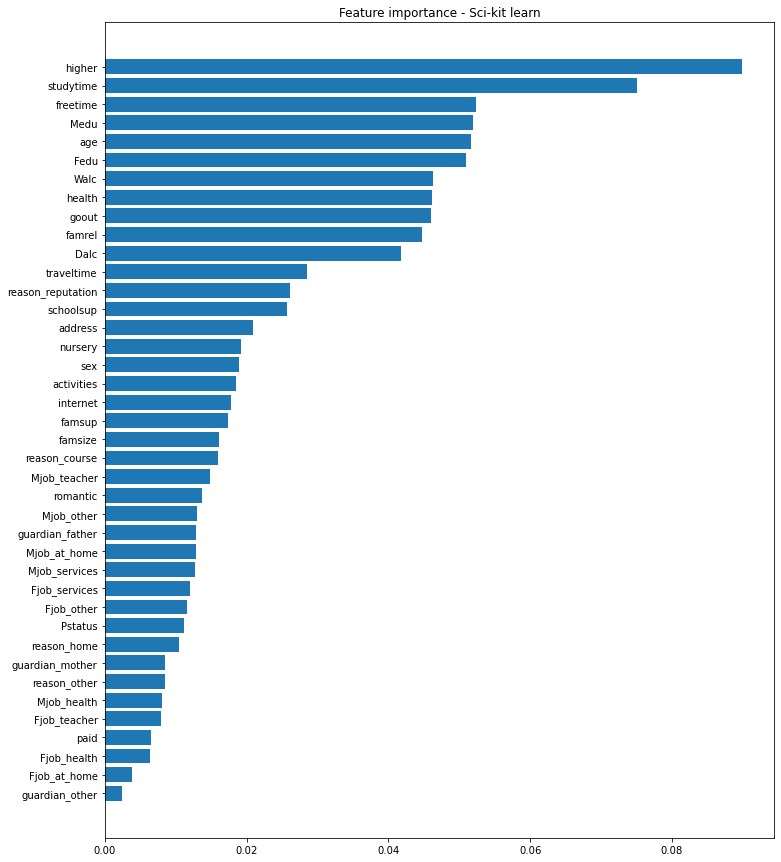

In [ ]:
fig = plt.figure(figsize = (12,15))
features_names = data.columns
f_importances(np.array(rf_random.best_estimator_.feature_importances_), features_names)
plt.title("Feature importance - Sci-kit learn")

Dal grafico notiamo che le 7 feature più importanti sono:
- studytime
- higher
- Medu
- Fedu
- freetime
- age
- Walc

Lo svantaggio di questo metodo è che ha la tendenza di sovrastimare l'importanza delle variabili continue e ordinali con alta cardinalità. 

Confronteremo queste importanze con gli altri approcci.

### Permutation Feature Importance

Con questo approccio confrontiamo R-square del moedllo con R-square di un modello dove i valori di una feature sono "mescolati" casualmente tra le osservazioni(mantendendo la distribuzione della feature). 

Una feature è importante se cambiare i suoi valori tra le osservazioni fa aumentare l'errore del modello. Una feature non è importante se cambiare i suoi valori tra le osservazioni non fa aumentare l'errore del modello

Applichiamo Permutation Importance su Training set, dato che ci interessa l'impatto delle feature sul voto G3.

(Traning set vs Test set? fonte: https://christophm.github.io/interpretable-ml-book/feature-importance.html)

In [ ]:
from sklearn.inspection import permutation_importance
from time import time
t0 = time()
result = permutation_importance(rf_random.best_estimator_, features_train, labels_train, n_repeats=10,
                                random_state=0, scoring = "neg_mean_absolute_error")
print("Computing Time:", round(time()-t0, 3), "s")

Computing Time: 47.668 s


Text(0.5, 1.0, 'Permutation Feature Importance')

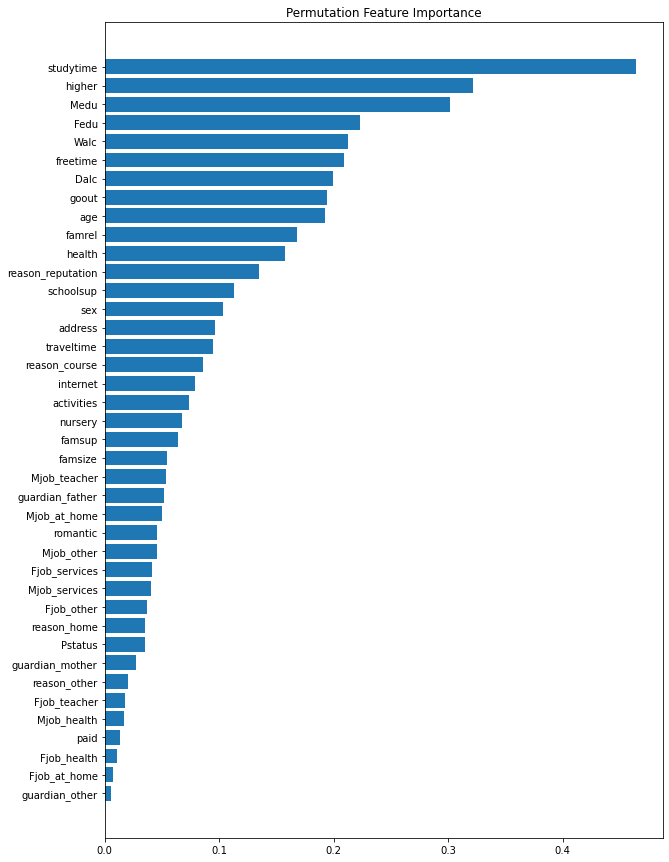

In [ ]:
plt.figure(figsize = (10,15))
f_importances(result["importances_mean"], feature_list)
plt.title("Permutation Feature Importance")

Con questo approccio le 7 feature più importanti sono:
- studytime
- Medu
- higher
- Fedu
- Walc
- goout 
- freetime

Notiamo che troviamo 6 delle 7 feature trovate nel primo approccio. In questo caso però al posto di age abbiamo Medu tra le feature più importanti.

Lo svantaggio di questo approccio è che sovrastima l'importanza delle feature molto correlate fra loro. School, higher e Dalc sono delle feature che hanno una moderata correlazione con G3. Confrontiamo questi risultati con l'ultimo approccio.

### Drop Column feature importances

Con questo approccio andiamo a misurare l'importanza di una feature confrontando R-square su training set del modello con tutte le feature contro un modello senza la feature che ci interessa. 

Una feature è importante se rimuoverla dal dataset fa aumentare l'errore del modello. Una feature non è importante se rimuoverla dal dataset non fa aumentare l'errore del modello

Anche in questo caso applichiamo questo approccio su training set.

L'approccio Drop Column è molto più preciso rispetto quelli precedenti. Il suo svantaggio è che è più lento a calcolare tutte le feature importances

In [ ]:
#fonte: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
from sklearn.base import clone 
def imp_df(column_names, importances):
    data = {
        'Feature': column_names,
        'Importance': importances,
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)

    return df
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [ ]:
features_train = pd.DataFrame(features_train, columns = feature_list)

t1 = time()
importanze = drop_col_feat_imp(rf_random.best_estimator_, features_train, labels_train)
print("Computing Time:", round(time()-t1, 3), "s")

Computing Time: 121.158 s


Text(0.5, 1.0, 'Drop Columns Feature Importance')

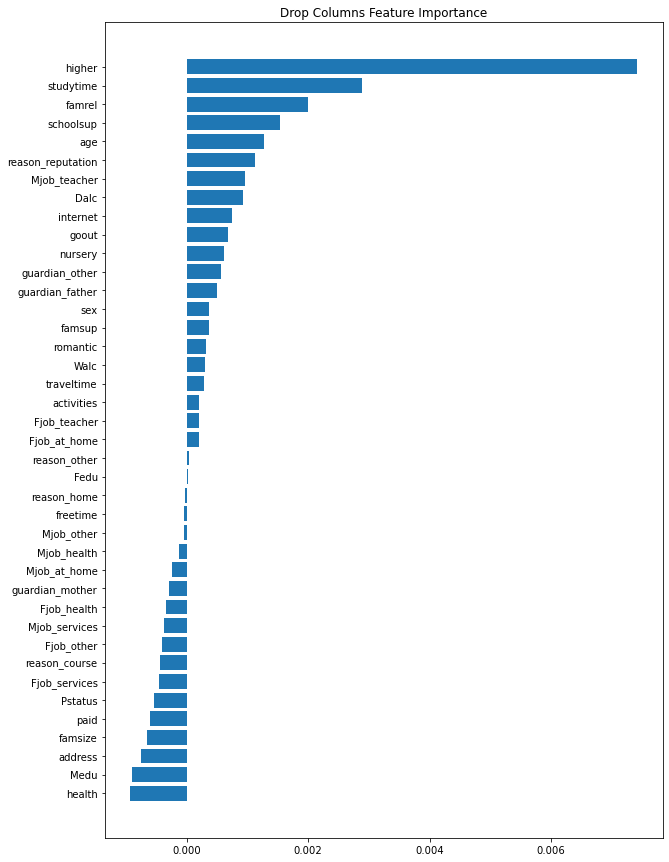

In [ ]:
plt.figure(figsize = (10,15))
f_importances(importanze["Importance"], importanze.index)
plt.title("Drop Columns Feature Importance")

Le 7features con un'importanza rilevante secondo l'approccio Drop Column sono, in ordine decrescente:
- higher
- schoolsup
- studytime
- famrel
- guardian_other
- reason_reputation
- sex

Con questo approccio la feature più importante è "higher". 







#### Osservazioni finali:
E' molto interessante notare quali sono i fattori che influiscono maggiormente sul voto finale degli studenti. 

Il tempo passato a studiare è il fattore che influisce più di tutti sul voto. Segue poi l'educazione dei genitori, il desiderio di continuare con gli studi, il consumo di alcool nei weekend e il tempo a disposizione.

## Conclusioni
1 - Abbiamo analizzato le relazioni tra i vari tipi di variabili, utilizzando il corretto coefficiente per misurare le associazioni tra di loro. Inoltre abbiamo dato importanza alle relazioni delle variabili con G3, visualizzando anche tramite grafici queste relazioni. 

2 - Abbiamo addrestrato 4 modelli diversi: SVR, Random Forest, KNN, Decision Tree. Utilizzando le corrette metriche abbiamo analizzato le performance dei modelli, migliorato le performance ottimizzando i loro iperparametri. I modelli che hanno dato le performance migliori sono Random Forest e SVR.

3 - Abbiamo preso il modello Random Forest e abbiamo analizzato l'impatto delle features sul voto finale G3. Utilizzando 3 approcci differenti, possiamo dire che le features che influiscono maggiormente sul voto finale sono: studytime, higher, Medu, Fedu, freetime e Walc.
